In [2]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
from concurrent import futures
import threading
from sklearn.model_selection import train_test_split
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

In [3]:
dataset_path = os.listdir('bengali_digits')

print (dataset_path)  #what kinds of classes are in this dataset

print("Types of classes labels found: ", len(dataset_path))

class_labels = []

for item in dataset_path:
 # Get all the file names
 all_classes = os.listdir('bengali_digits' + '/' +item)
 #print(all_classes)

 # Add them to the list
 for room in all_classes:
    class_labels.append((item, str('dataset_path' + '/' +item) + '/' + room))
    #print(class_labels[:5])
    
    
# Build a dataframe        
df = pd.DataFrame(data=class_labels, columns=['Labels', 'image'])
print(df.head())
print(df.tail())

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Types of classes labels found:  10
  Labels                                  image
0      0      dataset_path/0/1_14_BOG_1_317.jpg
1      0    dataset_path/0/1_22_Farid_3_318.jpg
2      0  dataset_path/0/1_B.BARIA_11_1_319.jpg
3      0  dataset_path/0/1_B.BARIA_11_1_320.jpg
4      0  dataset_path/0/1_B.BARIA_11_1_321.jpg
      Labels                                image
15615      9    dataset_path/9/1_TAN_1_1_1577.jpg
15616      9     dataset_path/9/1_THAK_13_316.jpg
15617      9  dataset_path/9/1_Tha_21_3_00032.jpg
15618      9  dataset_path/9/1_Tha_22_3_00033.jpg
15619      9  dataset_path/9/1_Tha_22_3_00035.jpg


In [4]:
# Let's check how many samples for each category are present
print("Total number of images in the dataset: ", len(df))

label_count = df['Labels'].value_counts()
print(label_count)


Total number of images in the dataset:  15620
Labels
3    1566
5    1565
7    1565
4    1564
6    1564
1    1563
8    1563
0    1561
2    1558
9    1551
Name: count, dtype: int64


In [5]:
import cv2
path = 'bengali_digits/'
dataset_path = os.listdir('bengali_digits')

IMG_DIMS = (224,224)
INPUT_SHAPE = (224,224, 3)

images = []
labels = []

for i in dataset_path:
    data_path = path + str(i)  
    filenames = [i for i in os.listdir(data_path) ]
   
    for f in filenames:
        img = cv2.imread(data_path + '/' + f)
        img = cv2.resize(img, IMG_DIMS)
        images.append(img)
        labels.append(i)

In [6]:
#This model takes input images of shape (224, 224, 3), and the input data should range [0, 255]. 

images = np.array(images)

images = images.astype('float32')/255.0
images.shape

(15620, 224, 224, 3)

In [7]:
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
y=df['Labels'].values
print(y)

y_labelencoder = LabelEncoder ()
y = y_labelencoder.fit_transform (y)
print (y)

['0' '0' '0' ... '9' '9' '9']
[0 0 0 ... 9 9 9]


In [8]:
y=y.reshape(-1,1)

from sklearn.compose import ColumnTransformer
ct = ColumnTransformer([('my_ohe', OneHotEncoder(sparse_output=False), [0])], remainder='passthrough')
Y = ct.fit_transform(y) #.toarray()
print(Y[:5])
print(Y[35:])

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [9]:
# Data Splitting
# Partition dataset into training(60),testing(30),validation(10) 
train_data, test_data, train_labels, test_labels = train_test_split(images, Y, test_size=0.3, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.1, random_state=42)

print(train_data.shape, val_data.shape, test_data.shape)

(9840, 224, 224, 3) (1094, 224, 224, 3) (4686, 224, 224, 3)


In [10]:
import tensorflow as tf
# Load the TensorBoard notebook extension (optional)
%load_ext tensorboard

#tf.random.set_random_seed(42)
tf.random.set_seed(42)
tf.__version__

'2.18.0'

In [11]:

incept = tf.keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', 
                                        input_shape=INPUT_SHAPE)
# Freeze the layers
incept.trainable = True

set_trainable = False
for layer in incept.layers:
    if layer.name in ['conv2d_367' , 'conv2d_369','conv2d_375', 'conv2d_86' ]:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
    
base_incept = incept
base_out = base_incept.output
pool_out = tf.keras.layers.Flatten()(base_out)
hidden1 = tf.keras.layers.Dense(512, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.2)(hidden2) 

out = tf.keras.layers.Dense(10, activation='softmax')(drop2)
#sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
#adam=Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model = tf.keras.Model(inputs=base_incept.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=.001,momentum=.9,nesterov=False),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 48,151,594 (183.68 MB)

 Trainable params: 31,504,394 (120.18 MB)

 Non-trainable params: 16,647,200 (63.50 MB)

 conv2d_61 (Conv2D)             (None, 8, 8, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 8, 8, 192)    258048      ['activation_65[0][0]']          
                                                                                                  
 batch_normalization_61 (BatchN  (None, 8, 8, 192)   576         ['conv2d_61[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_66 (BatchN  (None, 8, 8, 192)   576         ['conv2d_66[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 8, 8, 192)   576         ['conv2d_74[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_70 (Activation)     (None, 8, 8, 192)    0           ['batch_normalization_70[0][0]'] 
                                                                                                  
 activation_74 (Activation)     (None, 8, 8, 192)    0           ['batch_normalization_74[0][0]'] 
                                                                                                  
 conv2d_71 (Conv2D)             (None, 3, 3, 320)    552960      ['activation_70[0][0]']          
          

                                                                                                  
 activation_82 (Activation)     (None, 3, 3, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 3, 3, 384)    0           ['batch_normalization_83[0][0]'] 
                                                                                                  
 batch_normalization_84 (BatchN  (None, 3, 3, 192)   576         ['conv2d_84[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_76 (Activation)     (None, 3, 3, 320)    0           ['batch_normalization_76[0][0]'] 
                                                                                                  
 mixed9_0 

 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 3, 3, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 (Concatenate)         (None, 3, 3, 768)    0           ['activation_87[0][0]',          
                                                                  'activation_88[0][0]']          
                                                                                                  
 concatenate_1 (Concatenate)    (None, 3, 3, 768)    0           ['activation_91[0][0]',          
                                                                  'activation_92[0][0]']          
                                                                                                  
 activatio

In [12]:
print("Total Layers:", len(model.layers))
print("Total trainable layers:", 
      sum([1 for l in model.layers if l.trainable]))

Total Layers: 317
Total trainable layers: 34


In [13]:
#lrr= tf.keras.callbacks.ReduceLROnPlateau(
#                       monitor='val_accuracy', #Metric to be measured
#                       factor=.01, #Factor by which learning rate will be reduced
#                       patience=3,  #No. of epochs after which if there is no improvement in the val_acc, the learning rate is reduced
#                      min_lr=1e-7) #The minimum learning rate


EPOCHS = 25
history = model.fit(train_data, train_labels,
                    validation_data=(val_data, val_labels),
                    epochs=EPOCHS,
                    verbose=1)


Epoch 1/25
308/308 ━━━━━━━━━━━━━━━━━━━━ 326s 1s/step - accuracy: 0.7691 - loss: 0.7020 - val_accuracy: 0.9570 - val_loss: 0.1311
Epoch 2/25
308/308 ━━━━━━━━━━━━━━━━━━━━ 297s 963ms/step - accuracy: 0.9684 - loss: 0.0994 - val_accuracy: 0.9671 - val_loss: 0.0980
Epoch 3/25
308/308 ━━━━━━━━━━━━━━━━━━━━ 302s 981ms/step - accuracy: 0.9885 - loss: 0.0338 - val_accuracy: 0.9680 - val_loss: 0.0895
Epoch 4/25
308/308 ━━━━━━━━━━━━━━━━━━━━ 300s 974ms/step - accuracy: 0.9959 - loss: 0.0156 - val_accuracy: 0.9707 - val_loss: 0.0838
Epoch 5/25
308/308 ━━━━━━━━━━━━━━━━━━━━ 297s 966ms/step - accuracy: 0.9983 - loss: 0.0087 - val_accuracy: 0.9771 - val_loss: 0.0762
Epoch 6/25
308/308 ━━━━━━━━━━━━━━━━━━━━ 295s 959ms/step - accuracy: 0.9988 - loss: 0.0068 - val_accuracy: 0.9753 - val_loss: 0.0775
Epoch 7/25
308/308 ━━━━━━━━━━━━━━━━━━━━ 297s 965ms/step - accuracy: 0.9994 - loss: 0.0039 - val_accuracy: 0.9808 - val_loss: 0.0726
Epoch 8/25
308/308 ━━━━━━━━━━━━━━━━━━━━ 293s 953ms/step - accuracy: 0.9997 - lo

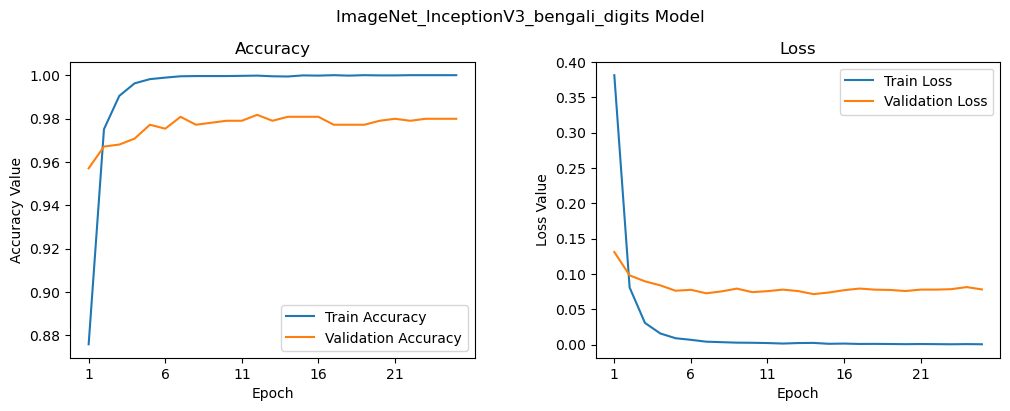

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('ImageNet_InceptionV3_bengali_digits Model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

plt.savefig('Train_Graph_ImageNet_InceptionV3_bengali_digits.png')

In [15]:
model.save('ImageNet_InceptionV3_bengali_digits.h5')

In [16]:
#scale test data
test_data.shape, test_labels.shape

((4686, 224, 224, 3), (4686, 10))

In [17]:
# Load Saved Deep Learning Models
model = tf.keras.models.load_model('ImageNet_InceptionV3_bengali_digits.h5')

y_pre_test=model.predict(test_data)
y_pre_test=np.argmax(y_pre_test,axis=1)
categories = ['0','1','2','3','4','5','6','7','8','9']

147/147 ━━━━━━━━━━━━━━━━━━━━ 113s 747ms/step


In [18]:
# Model evaluated on training data
score = model.evaluate(train_data, train_labels, verbose=0)
print('Training score:', score[0])
print('Training accuracy:', score[1] * 100)

Training score: 4.978965444024652e-05
Training accuracy: 100.0


In [19]:
# Model evaluated on validation data
score = model.evaluate(val_data, val_labels, verbose=0)
print('Validation score:', score[0])
print('Validation accuracy:', score[1] * 100)

Validation score: 0.07808282226324081
Validation accuracy: 97.98902869224548


In [20]:
# Model evaluated on test data
score = model.evaluate(test_data, test_labels, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1]  * 100)

Test score: 0.10300083458423615
Test accuracy: 97.6952612400055


In [21]:
import numpy as np
rounded_labels=np.argmax(test_labels, axis=1)
rounded_labels[0]

2

In [22]:
clf_report = pd.DataFrame(classification_report(rounded_labels, y_pre_test, target_names=categories, output_dict=True))
cm = confusion_matrix(rounded_labels, y_pre_test)
print("Test Result:\n================================================")
print(f"Accuracy Score: {accuracy_score(rounded_labels, y_pre_test) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{clf_report}")

Test Result:
Accuracy Score: 97.70%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1           2           3           4  \
precision    0.991323    0.973626    0.972803    0.985772    0.978214   
recall       0.993478    0.932632    0.978947    0.983773    0.991170   
f1-score     0.992400    0.952688    0.975866    0.984772    0.984649   
support    460.000000  475.000000  475.000000  493.000000  453.000000   

                    5           6           7           8           9  \
precision    0.977551    0.978858    0.991111    0.984683    0.936306   
recall       0.973577    0.978858    0.993318    0.984683    0.960784   
f1-score     0.975560    0.978858    0.992214    0.984683    0.948387   
support    492.000000  473.000000  449.000000  457.000000  459.000000   

           accuracy    macro avg  weighted avg  
precision  0.976953     0.977025      0.977040  
recall     0.976953     0.977122      0.976953  
f1-score   0.9

In [23]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    #y_score = clf.decision_function(X_test)
    y_score=model.predict(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sn.despine()
    plt.show()

147/147 ━━━━━━━━━━━━━━━━━━━━ 109s 741ms/step


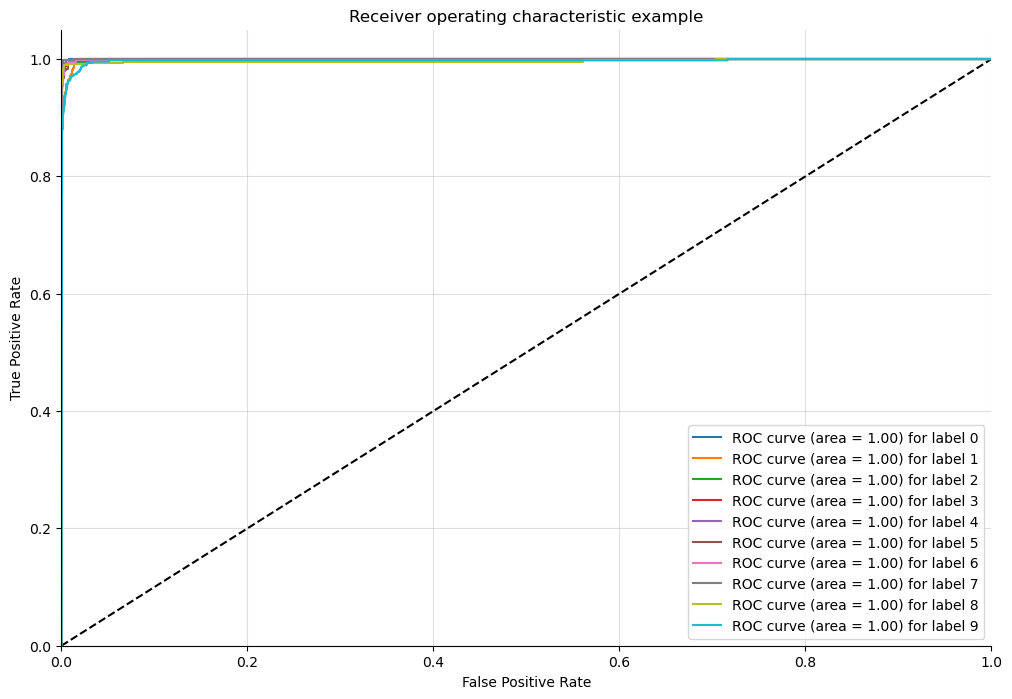

In [24]:
plot_multiclass_roc(model, test_data, rounded_labels, n_classes=10, figsize=(12, 8))

In [25]:
# ROC AUC scores
y_pred=model.predict(test_data)
macro_roc_auc_ovo = roc_auc_score(test_labels, y_pred, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(test_labels, y_pred, multi_class="ovo", average="weighted")

macro_roc_auc_ovr = roc_auc_score(test_labels, y_pred, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(test_labels, y_pred, multi_class="ovr", average="weighted")
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
)
print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
)

147/147 ━━━━━━━━━━━━━━━━━━━━ 111s 752ms/step
One-vs-One ROC AUC scores:
0.999175 (macro),
0.999186 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.999175 (macro),
0.999186 (weighted by prevalence)


In [26]:
# Confusion Matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

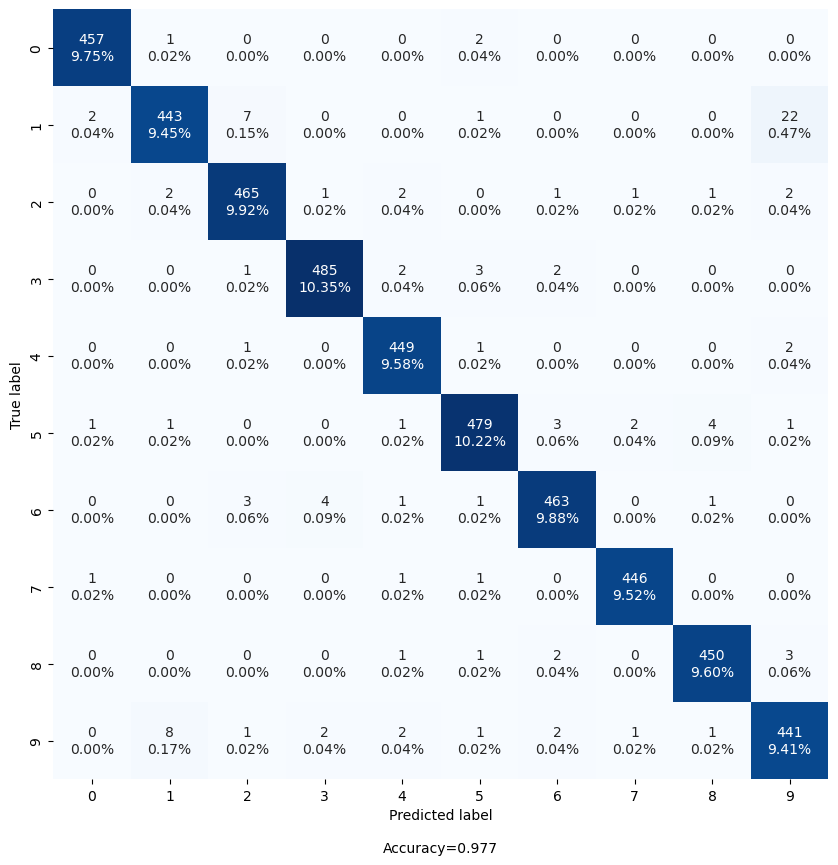

In [27]:
categories = ['0','1','2','3','4','5','6','7','8','9']
make_confusion_matrix(cm, categories=categories,figsize=(10,10), cbar=False)
plt.savefig("ConfusionMatrix_InceptionV3.png")

## PREDICTIONS

In [8]:
## PREDICTIONS

import tensorflow as tf
import numpy as np
from PIL import Image

# Load the saved model
model = tf.keras.models.load_model('ImageNet_InceptionV3_bengali_digits.h5')

# Define a function for preprocessing
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((224, 224))  # Adjust size as per your model's input
    image = np.array(image) / 255.0  # Normalize to [0, 1] range
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Predict
def predict(image_path):
    image = preprocess_image(image_path)
    predictions = model.predict(image)
    return np.argmax(predictions, axis=1)  # Assuming classification

In [10]:
result = predict(r"C:\Users\sakib\Desktop\CSE713\bengali_digits\9\1_BAR_11_1_353.jpg")
print("Predicted Class:", result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Class: [9]
